In [38]:
import pandas as pd
import sqlite3
import requests
import matplotlib

In [39]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey=ODC7ODEN06DAVQGG&outputsize=full"

In [40]:
"""
    API_KEY
    GET Your API KEY FROM https://www.alphavantage.co/support/#api-key for free of Charg
"""
API_KEY = "YOUR_API_KEY"

def fetch_intraday_data(ticker,interval='1min'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={ticker}&interval=1min&apikey={API_KEY}&outputsize=full'
    response = requests.get(url)
    data = response.json()
    # print(data)
    time_series = data.get(f'Time Series ({interval})',{})
    if not time_series:
        print(f"No Data retuned for {ticker}")
        return None
    dataframe = pd.DataFrame(time_series).T
    dataframe.index.name = 'timestamp'
    dataframe.columns=['open','high','low','close','volume']
    dataframe = dataframe.sort_index()
    dataframe.reset_index(inplace=True)
    dataframe['ticker'] = ticker
    return dataframe
    

In [41]:
dataframe = fetch_intraday_data('IBM')


<Axes: xlabel='timestamp'>

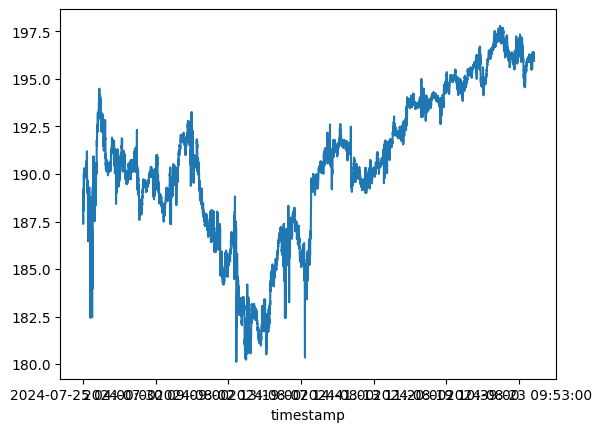

In [42]:
dataframe.set_index('timestamp').close.astype(float).plot()

In [43]:
connection = sqlite3.connect("python_sql.db")
cursor = connection.cursor()
cursor.execute(
    '''
    CREATE TABLE IF NOT EXISTS python_sql_prices(
        ticker TEXT,
        timestamp TEXT,
        open REAL,
        high REAl,
        low REAL,
        close REAL,
        volume INTEGER
    )
    '''
)
connection.commit()

In [48]:
def get_latest_timestamp(ticker):
    query = """SELECT MAX(timestamp) FROM python_sql_prices WHERE ticker = ?"""
    cursor.execute(query,(ticker,))
    result = cursor.fetchone()[0]
    return result

In [49]:
get_latest_timestamp('IBM')

In [50]:
def store_data_to_db(data,latest_timestamp):
    if data is not None:
        if latest_timestamp:
            data = data[data['timestamp'] > latest_timestamp]
        if not data.empty:
            data.to_sql('python_sql_prices',connection,if_exists='append',index=False)
            print(f"Data for {data['ticker'].iloc[0]} stored successfully!")
        else:
            print("No new data to add!")
    else:
        print("No data to add!")


In [51]:
def main():
    tickers = ['IBM','MSFT']
    for ticker in tickers:
        latest_timestamp = get_latest_timestamp(ticker=ticker)
        data = fetch_intraday_data(ticker)
        store_data_to_db(data=data,latest_timestamp=latest_timestamp)
        
if __name__ == "__main__":
    main()

Data for IBM stored successfully!
Data for MSFT stored successfully!


In [52]:
def query_data(ticker,start_time,end_time):
    query = f"""
    SELECT * FROM python_sql_prices WHERE ticker= '{ticker}'
    AND timestamp BETWEEN '{start_time}' AND '{end_time}'
    """
    dataframe = pd.read_sql(query,connection)
    return dataframe

In [53]:
dataframe = query_data(ticker='IBM',start_time='2024-08-23 00:00:00',end_time='2024-08-23 19:59:00')
dataframe

,ticker,timestamp,open,high,low,close,volume
0,IBM,2024-08-23 04:00:00,196.25,196.25,196.25,196.25,35
1,IBM,2024-08-23 04:01:00,196.27,196.27,196.27,196.27,30
2,IBM,2024-08-23 04:02:00,196.42,196.51,196.27,196.45,18
3,IBM,2024-08-23 04:05:00,196.26,196.26,196.26,196.26,1
4,IBM,2024-08-23 04:09:00,196.27,196.27,196.27,196.27,1
...,...,...,...,...,...,...,...
485,IBM,2024-08-23 19:43:00,195.98,196.10,195.98,196.10,16
486,IBM,2024-08-23 19:46:00,196.11,196.11,196.11,196.11,6
487,IBM,2024-08-23 19:55:00,195.95,195.95,195.95,195.95,27
488,IBM,2024-08-23 19:56:00,196.14,196.14,196.10,196.10,30
